In [7]:
# Cell 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from keras.utils import custom_object_scope
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.layers import GRUCell

C:\Users\annek\AppData\Local\Temp\ipykernel_12224\37937776.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
C:\Users\annek\AppData\Local\Temp\ipykernel_12224\37937776.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)


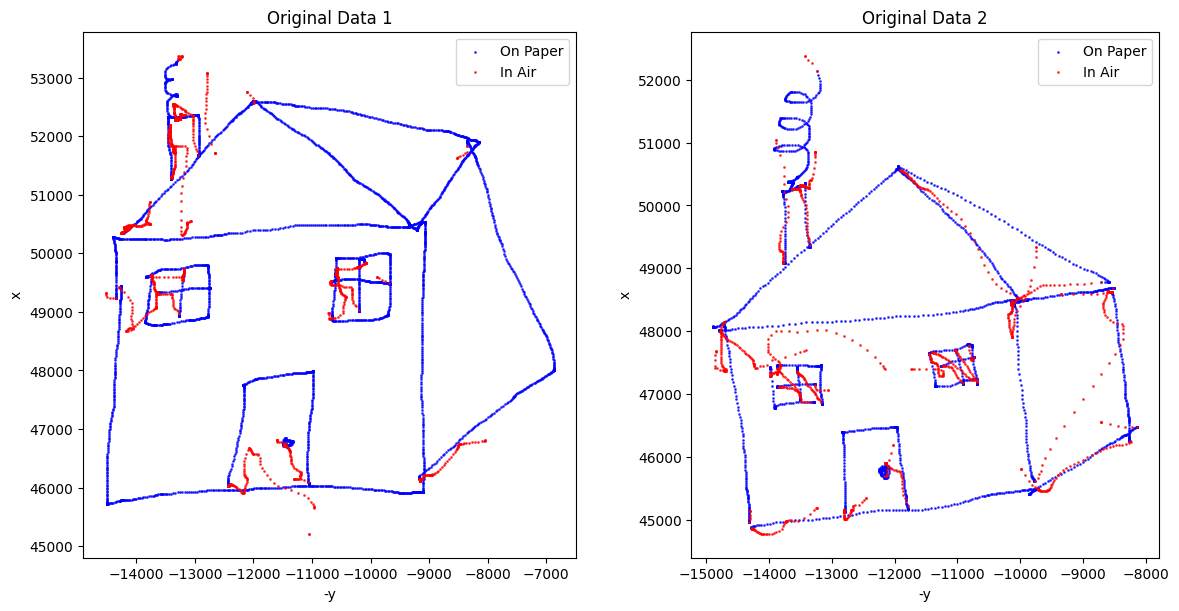

Number of processed files: 2
Average number of data points: 4387


In [8]:
# Cell 2
# Updated function
# Updated function without saving data inside
def upload_and_process_files(directory, num_files_to_use=None):
    svc_files = [f for f in os.listdir(directory) if f.endswith('.svc')]
    
    # If num_files_to_use is specified, only take that many files sequentially
    if num_files_to_use:
        svc_files = svc_files[:num_files_to_use]  # Take the first num_files_to_use files

    data_frames = []  # Processed data after scaling
    original_data_frames = []  # Save the original unscaled data
    scalers = []
    input_filenames = []  # List to store input filenames

    num_files = len(svc_files)
    fig, axs = plt.subplots(1, num_files, figsize=(6*num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]

    for i, filename in enumerate(svc_files):
        file_path = os.path.join(directory, filename)
        input_filenames.append(filename)  # Store the filename
        df = pd.read_csv(file_path, skiprows=1, header=None, delim_whitespace=True)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        # Modify timestamp to start from 0
        df['timestamp'] = (df['timestamp'] - df['timestamp'].min()).round().astype(int)
        
        # Keep a copy of the original data before scaling
        original_data_frames.append(df.copy())  # Save the original unmodified data
        
        # Process the data for use in the model
        df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6]] 
        data_frames.append(df)
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(df[['x', 'y', 'timestamp']])
        scalers.append(scaler)

        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]
        axs[i].scatter(-on_paper['y'], on_paper['x'], c='blue', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(-in_air['y'], in_air['x'], c='red', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Original Data {i + 1}')
        axs[i].set_xlabel('-y')
        axs[i].set_ylabel('x')
        axs[i].legend()
        axs[i].set_aspect('equal')

    plt.show()

    processed_data = [np.column_stack((scaler.transform(df[['x', 'y', 'timestamp']]), df['pen_status'].values)) 
                      for df, scaler in zip(data_frames, scalers)]
    avg_data_points = int(np.mean([df.shape[0] for df in data_frames]))

    return data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames  # Return original data

# Save data outside the function
def save_original_data(data_frames, input_filenames, output_folder='original_absolute'):
    os.makedirs(output_folder, exist_ok=True)
    for df, filename in zip(data_frames, input_filenames):
        save_path = os.path.join(output_folder, filename)
        df.to_csv(save_path, sep=' ', index=False, header=False)

directory = 'Task2'  # Directory where the .svc files are stored
num_files_to_use = 2
data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames = upload_and_process_files(directory, num_files_to_use)

# Save the original data after processing
save_original_data(original_data_frames, input_filenames)

# Store the name of the first file for use in Cell 4
input_filename = input_filenames[0] if input_filenames else 'processed_data'
print(f"Number of processed files: {len(processed_data)}")
print(f"Average number of data points: {avg_data_points}")


In [ ]:
# Cell 6 (modified)
class VRNN(tf.keras.Model):
    def __init__(self, latent_dim, hidden_dim=256, feature_dim=128, beta=1.0, **kwargs):
        super(VRNN, self).__init__(**kwargs)
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.feature_dim = feature_dim
        self.beta = beta
        
        # Feature extractors
        self.phi_x = tf.keras.Sequential([
            Dense(feature_dim, activation='relu'),
            Dense(feature_dim, activation='relu')
        ])
        
        self.phi_z = tf.keras.Sequential([
            Dense(feature_dim, activation='relu'),
            Dense(feature_dim, activation='relu')
        ])
        
        # Prior network
        self.prior = tf.keras.Sequential([
            Dense(hidden_dim, activation='relu'),
            Dense(latent_dim * 2)  # Mean and logvar
        ])
        
        # Encoder network
        self.encoder = tf.keras.Sequential([
            Dense(hidden_dim, activation='relu'),
            Dense(hidden_dim, activation='relu'),
            Dense(latent_dim * 2)  # Mean and logvar
        ])
        
        # Decoder network
        self.decoder = tf.keras.Sequential([
            Dense(hidden_dim, activation='relu'),
            Dense(hidden_dim, activation='relu'),
            Dense(4)  # x, y, timestamp, pen_status
        ])
        
        # RNN cell
        self.rnn = GRUCell(hidden_dim)
    
    def encode(self, x, h):
        # Extract features from input
        phi_x = self.phi_x(x)
        
        # Concatenate features with hidden state
        encoder_input = tf.concat([phi_x, h], axis=-1)
        
        # Get mean and logvar from encoder
        mean, logvar = tf.split(self.encoder(encoder_input), 
                              num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def prior_distribution(self, h):
        # Generate prior distribution parameters based on hidden state
        mean, logvar = tf.split(self.prior(h), 
                              num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean
    
    def decode(self, z, h):
        # Extract features from latent
        phi_z = self.phi_z(z)
        
        # Concatenate with hidden state
        decoder_input = tf.concat([phi_z, h], axis=-1)
        
        # Generate output
        output = self.decoder(decoder_input)
        
        # Split and apply activations
        xy_timestamp = tf.sigmoid(output[:, :3])
        pen_status = tf.sigmoid(output[:, 3])
        
        return tf.concat([xy_timestamp, tf.expand_dims(pen_status, -1)], axis=1)
    
    def get_initial_state(self, batch_size):
        return tf.zeros((batch_size, self.hidden_dim))
    
    def call(self, inputs, initial_state=None):
        # Initialize hidden state if not provided
        batch_size = tf.shape(inputs)[0]
        if initial_state is None:
            h = self.get_initial_state(batch_size)
        else:
            h = initial_state
            
        # Process sequence
        outputs = []
        z_means, z_logvars = [], []
        prior_means, prior_logvars = [], []
        
        for t in range(tf.shape(inputs)[1]):
            x_t = inputs[:, t, :]
            
            # Get prior distribution
            prior_mean, prior_logvar = self.prior_distribution(h)
            
            # Encode input
            z_mean, z_logvar = self.encode(x_t, h)
            
            # Sample latent
            z = self.reparameterize(z_mean, z_logvar)
            
            # Decode
            output = self.decode(z, h)
            
            # Update hidden state
            phi_x = self.phi_x(x_t)
            phi_z = self.phi_z(z)
            rnn_input = tf.concat([phi_x, phi_z], axis=-1)
            h = self.rnn(rnn_input, [h])[0]
            
            # Store results
            outputs.append(output)
            z_means.append(z_mean)
            z_logvars.append(z_logvar)
            prior_means.append(prior_mean)
            prior_logvars.append(prior_logvar)
        
        # Stack time dimension
        outputs = tf.stack(outputs, axis=1)
        z_means = tf.stack(z_means, axis=1)
        z_logvars = tf.stack(z_logvars, axis=1)
        prior_means = tf.stack(prior_means, axis=1)
        prior_logvars = tf.stack(prior_logvars, axis=1)
        
        return outputs, z_means, z_logvars, prior_means, prior_logvars, h

def compute_vrnn_loss(model, x):
    # Forward pass
    x_reconstructed, z_means, z_logvars, prior_means, prior_logvars, _ = model(x)
    
    # Reconstruction loss
    reconstruction_loss_xy_timestamp = tf.reduce_mean(
        tf.keras.losses.mse(x[:, :, :3], x_reconstructed[:, :, :3]))
    reconstruction_loss_pen = tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(x[:, :, 3], x_reconstructed[:, :, 3]))
    
    # KL divergence loss
    kl_loss = -0.5 * tf.reduce_mean(
        1 + z_logvars - prior_logvars 
        - tf.exp(z_logvars) / tf.exp(prior_logvars)
        - tf.square(z_means - prior_means) / tf.exp(prior_logvars)
    )
    
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


# New: LSTM Discriminator for GAN
class LSTMDiscriminator(tf.keras.Model):
    def __init__(self):
        super(LSTMDiscriminator, self).__init__()
        self.model = Sequential()
        self.model.add(LSTM(64, return_sequences=True, input_shape=(None, 4)))  # LSTM for sequence learning
        self.model.add(LSTM(32))
        self.model.add(Dense(1, activation='sigmoid'))  # Binary classification

    def call(self, x):
        return self.model(x)


# Function to compute VAE loss
def compute_loss(model, x):
    x_reconstructed, mean, logvar = model(x)
    reconstruction_loss_xy_timestamp = tf.reduce_mean(tf.keras.losses.mse(x[:, :3], x_reconstructed[:, :3]))
    reconstruction_loss_pen = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x[:, 3], x_reconstructed[:, 3]))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss_xy_timestamp + reconstruction_loss_pen, kl_loss, model.beta * kl_loss


# Parameters for VAE
latent_dim = 1024
beta = 0.001
learning_rate = 0.001
lambda_shift = 0.5

vae = VAE(latent_dim, beta, lambda_shift)
optimizer = tf.keras.optimizers.Adam(learning_rate)


In [10]:
# Cell 7 (modified)
# Replace current generation with:
def generate_sequence_vrnn(model, seq_length, batch_size=1):
    # Initialize hidden state
    h = model.get_initial_state(batch_size)
    
    # Initialize first input (can be random or zeros)
    x = tf.zeros((batch_size, 4))
    
    generated_sequence = []
    for t in range(seq_length):
        # Get prior distribution
        prior_mean, prior_logvar = model.prior_distribution(h)
        
        # Sample from prior
        z = model.reparameterize(prior_mean, prior_logvar)
        
        # Decode
        output = model.decode(z, h)
        
        # Update hidden state
        phi_x = model.phi_x(x)
        phi_z = model.phi_z(z)
        rnn_input = tf.concat([phi_x, phi_z], axis=-1)
        h = model.rnn(rnn_input, [h])[0]
        
        # Store output and use it as next input
        generated_sequence.append(output)
        x = output
    
    return tf.stack(generated_sequence, axis=1)

def generate_augmented_data_vrnn(model, num_sequences, sequence_length):
    augmented_datasets = []
    for _ in range(num_sequences):
        sequence = generate_sequence_vrnn(model, sequence_length)
        augmented_datasets.append(sequence.numpy())
    return augmented_datasets

# The post_process_pen_status function remains unchanged
def post_process_pen_status(pen_status, threshold=0.5, min_segment_length=5):
    binary_pen_status = (pen_status > threshold).astype(int)
    
    # Smooth out rapid changes
    for i in range(len(binary_pen_status) - min_segment_length):
        if np.all(binary_pen_status[i:i+min_segment_length] == binary_pen_status[i]):
            binary_pen_status[i:i+min_segment_length] = binary_pen_status[i]
    
    return binary_pen_status

In [11]:
#Cell 8
@tf.function
def train_vrnn_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        reconstruction_loss, kl_loss, total_kl_loss = compute_vrnn_loss(model, x)
        total_loss = reconstruction_loss + total_kl_loss
    
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, reconstruction_loss, kl_loss



def prepare_sequences(data, sequence_length):
    """Prepare data as sequences for VRNN"""
    sequences = []
    for d in data:
        for i in range(0, len(d) - sequence_length + 1, sequence_length):
            sequences.append(d[i:i + sequence_length])
    return np.array(sequences)

@tf.function
def train_lstm_step(lstm_model, real_data, generated_data, optimizer):
    with tf.GradientTape() as tape:
        real_predictions = lstm_model(real_data)
        generated_predictions = lstm_model(generated_data)
        real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_predictions), real_predictions)
        generated_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(generated_predictions), generated_predictions)
        total_loss = real_loss + generated_loss
    gradients = tape.gradient(total_loss, lstm_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lstm_model.trainable_variables))
    return total_loss

# Initialize LSTM discriminator and optimizer
lstm_discriminator = LSTMDiscriminator()
lstm_optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 512
# Add this before training
sequence_length = 64  # Choose appropriate length
sequences = prepare_sequences(processed_data, sequence_length)
train_dataset = tf.data.Dataset.from_tensor_slices(sequences).shuffle(10000).batch(batch_size)

# Set up alternating epochs
vae_epochs = 200
lstm_interval = 50
epochs = 100
visual_per_num_epoch = 20
num_augmented_files = 2

generator_loss_history = []
reconstruction_loss_history = []
kl_loss_history = []
nrmse_history = []

save_dir = "vae_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Replace current training loop with:
for epoch in range(epochs):
    total_loss = 0
    reconstruction_loss_sum = 0
    kl_loss_sum = 0
    
    with tqdm(total=len(train_dataset), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for batch in train_dataset:
            loss, rec_loss, kl = train_vrnn_step(vrnn, batch, optimizer)
            total_loss += loss
            reconstruction_loss_sum += rec_loss
            kl_loss_sum += kl
            pbar.update(1)
            pbar.set_postfix({'Loss': float(loss),
                            'Reconstruction': float(rec_loss),
                            'KL': float(kl)})
            
    # Train LSTM every `lstm_interval` epochs after `vae_epochs`
    if epoch >= vae_epochs and (epoch - vae_epochs) % lstm_interval == 0:
        for data in processed_data:
            augmented_data = vae.decode(tf.random.normal(shape=(data.shape[0], latent_dim))).numpy()
            real_data = tf.expand_dims(data, axis=0)
            generated_data = tf.expand_dims(augmented_data, axis=0)
            lstm_loss = train_lstm_step(lstm_discriminator, real_data, generated_data, lstm_optimizer)
        print(f'LSTM training at epoch {epoch+1}: Discriminator Loss = {lstm_loss.numpy()}')


    avg_generator_loss = generator_loss / num_batches  # Update the average calculation
    avg_reconstruction_loss = reconstruction_loss_sum / num_batches
    avg_kl_loss = kl_loss_sum / num_batches

    generator_loss_history.append(avg_generator_loss)  # Update history list
    reconstruction_loss_history.append(avg_reconstruction_loss)
    kl_loss_history.append(avg_kl_loss)



    print(f"Epoch {epoch+1}: Generator Loss = {avg_generator_loss:.6f}, Reconstruction Loss = {avg_reconstruction_loss:.6f}, KL Divergence Loss = {avg_kl_loss:.6f}")



    # Cell 5 (visualization part)
    if (epoch + 1) % visual_per_num_epoch == 0:
        base_latent_variability = 100.0
        latent_variability_range = (0.1, 5.0)

        augmented_datasets = generate_augmented_data(vae, num_augmented_files, avg_data_points, processed_data, 
                                                     base_latent_variability, latent_variability_range)

        # Calculate actual latent variabilities and lengths used
        latent_variabilities = [base_latent_variability * np.random.uniform(latent_variability_range[0], latent_variability_range[1]) for _ in range(num_augmented_files)]
        augmented_lengths = [len(data) for data in augmented_datasets]

        fig, axs = plt.subplots(1, num_augmented_files + len(original_data_frames), figsize=(6*(num_augmented_files + len(original_data_frames)), 6))

        for i, original_data in enumerate(original_data_frames):
            original_on_paper = original_data[original_data['pen_status'] == 1]
            original_in_air = original_data[original_data['pen_status'] == 0]

            axs[i].scatter(original_on_paper['y'], original_on_paper['x'], c='b', s=1, label='On Paper')
            axs[i].scatter(original_in_air['y'], original_in_air['x'], c='r', s=1, label='In Air')
            axs[i].set_title(f'Original Data {i+1}')
            axs[i].invert_xaxis()

        # Set consistent axis limits for square aspect ratio for both original and augmented data
        x_min = min(data[:, 0].min() for data in processed_data)
        x_max = max(data[:, 0].max() for data in processed_data)
        y_min = min(data[:, 1].min() for data in processed_data)
        y_max = max(data[:, 1].max() for data in processed_data)

        for i, (augmented_data, latent_var, length) in enumerate(zip(augmented_datasets, latent_variabilities, augmented_lengths)):
            augmented_on_paper = augmented_data[augmented_data[:, 3] == 1]
            augmented_in_air = augmented_data[augmented_data[:, 3] == 0]

            axs[i+len(original_data_frames)].scatter(augmented_on_paper[:, 1], augmented_on_paper[:, 0], c='b', s=1, label='On Paper')
            axs[i+len(original_data_frames)].scatter(augmented_in_air[:, 1], augmented_in_air[:, 0], c='r', s=1, label='In Air')
            axs[i+len(original_data_frames)].invert_xaxis()
            axs[i+len(original_data_frames)].set_xlim(y_max, y_min)
            axs[i+len(original_data_frames)].set_ylim(x_min, x_max)

        plt.tight_layout()
        plt.show()
        # Save VAE model after each epoch, directly into the `vae_models` folder
        model_save_path = os.path.join(save_dir, f"epoch_{epoch+1}_model.h5")
        vae.save(model_save_path)
        print(f"VAE model saved for epoch {epoch+1} at {model_save_path}.")

# Final output and plots
plt.ioff()
plt.show()

vae.save('pentab_saved_model.h5')
print("Final VAE model saved.")

# Plot generator loss history
plt.figure(figsize=(10, 5))
plt.plot(generator_loss_history, label='Generator Loss')  # Update label
plt.plot(reconstruction_loss_history, label='Reconstruction Loss')
plt.plot(kl_loss_history, label='KL Divergence Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

C:\Users\annek\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Epoch 1/100:   0%|          | 0/1 [00:00<?, ?batch/s]


NameError: name 'optimizer' is not defined

In [ ]:
# Cell 10
import shutil

# Base latent variability settings
base_latent_variability = 100.0
latent_variability_range = (0.99, 1.01)
all_augmented_data = []  # Global list to store all augmented data

def repeat_backwards(original_paa, augmented_length):
    repeat_count = augmented_length - len(original_paa)
    if repeat_count <= 0:
        return original_paa
    backwards_rows = np.empty((0, original_paa.shape[1]))
    for i in range(repeat_count):
        row_to_repeat = original_paa[-(i % len(original_paa) + 1)]
        backwards_rows = np.vstack((backwards_rows, row_to_repeat))
    return np.vstack((original_paa, backwards_rows))

def visualize_augmented_data_from_directory(directory):
    augmented_files = [f for f in os.listdir(directory) if f.startswith('augmented_') and f.endswith('.svc')]
    num_files = len(augmented_files)
    if num_files == 0:
        print("No augmented data files found in the directory.")
        return
    
    fig, axs = plt.subplots(1, num_files, figsize=(6 * num_files, 6), constrained_layout=True)
    if num_files == 1:
        axs = [axs]
    
    for i, filename in enumerate(augmented_files):
        file_path = os.path.join(directory, filename)
        df = pd.read_csv(file_path, delim_whitespace=True, header=None)
        df.columns = ['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude']
        
        on_paper = df[df['pen_status'] == 1]
        in_air = df[df['pen_status'] == 0]

        axs[i].scatter(on_paper['y'], on_paper['x'], c='b', s=1, alpha=0.7, label='On Paper')
        axs[i].scatter(in_air['y'], in_air['x'], c='r', s=1, alpha=0.7, label='In Air')
        axs[i].set_title(f'Augmented Data {i + 1}')
        axs[i].set_xlabel('y')
        axs[i].set_ylabel('x')
        axs[i].invert_xaxis()
        axs[i].set_aspect('equal')
        axs[i].legend()
    
    plt.show()

def get_unique_filename(directory, filename):
    base, extension = os.path.splitext(filename)
    counter = 1
    while os.path.exists(os.path.join(directory, filename)):
        filename = f"{base}({counter}){extension}"
        counter += 1
    return filename

def download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, original_filenames, directory1='augmented_data', directory2='augmented_data_nested'):
    global all_augmented_data  # Access the global list

    if not os.path.exists(directory1):
        os.makedirs(directory1)
    
    if not os.path.exists(directory2):
        os.makedirs(directory2)

    for i, (augmented_data, scaler, original_df, original_filename) in enumerate(zip(augmented_datasets, scalers, original_data_frames, original_filenames)):
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        pen_status = augmented_data[:, 3].astype(int)
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        if len(augmented_data) > len(original_paa):
            original_paa = repeat_backwards(original_paa, len(augmented_data))
        
        original_paa_int = np.rint(original_paa).astype(int)
        
        new_timestamps = np.zeros(len(augmented_data), dtype=int)
        increment_sequence = [7, 8]
        current_time = 0
        for idx in range(len(augmented_data)):
            new_timestamps[idx] = current_time
            current_time += increment_sequence[idx % 2]

        augmented_xyz_int[:, 2] = new_timestamps

        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))

        # Use the original filename for nested directory
        nested_filename = original_filename
        nested_file_path = os.path.join(directory2, nested_filename)

        # For augmented_data directory, add 'augmented_' prefix and handle duplicates
        augmented_filename = f"synthetic_{original_filename}"
        augmented_filename = get_unique_filename(directory1, augmented_filename)
        augmented_file_path = os.path.join(directory1, augmented_filename)

        np.savetxt(augmented_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')
        np.savetxt(nested_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')

        # Only store augmented data from the augmented_data directory
        all_augmented_data.append(augmented_data_original_scale)

        print(f"Augmented data saved to {augmented_file_path}")
        print(f"Augmented data saved to {nested_file_path}")
        print(f"Shape of augmented data for {original_filename}: {augmented_data_original_scale.shape}")

def nested_augmentation(num_augmentations, num_files_to_use):
    with custom_object_scope({'VAE': VAE}):
        vae_pretrained = load_model('vae_models/epoch_100_model.h5')
    print("Pretrained VAE model loaded.")

    # Use the existing data for the first iteration
    global data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames

    for iteration in range(num_augmentations):
        print(f"Starting augmentation iteration {iteration + 1}")
        
        if iteration > 0:
            # Only update the data for subsequent iterations
            directory = 'augmented_data_nested'
            data_frames, processed_data, scalers, avg_data_points, input_filenames, original_data_frames = upload_and_process_files(directory, num_files_to_use)
        
        augmented_datasets = generate_augmented_data(vae_pretrained, num_files_to_use, avg_data_points, processed_data, 
                                                     base_latent_variability, latent_variability_range)
        
        # Clear augmented_data_nested directory
        if os.path.exists('augmented_data_nested'):
            shutil.rmtree('augmented_data_nested')
        os.makedirs('augmented_data_nested')
        
        download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, input_filenames)
        
        print(f"Completed augmentation iteration {iteration + 1}")
    
    # Clear augmented_data_nested directory after the last iteration
    if os.path.exists('augmented_data_nested'):
        shutil.rmtree('augmented_data_nested')
        print("Cleared augmented_data_nested directory after the final iteration.")
    
    print("Nested augmentation process completed.")
    visualize_augmented_data_from_directory('augmented_data')
    

# Set the number of augmentations and files to use
num_augmentations = 3  # Change this to control the number of nested augmentations

# Run the nested augmentation process
nested_augmentation(num_augmentations, num_files_to_use)

ValueError: Unknown layer: 'VRNN'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [99]:
# Cell 11 NRMSE
from glob import glob
import re

def read_svc_file(file_path):
    return pd.read_csv(file_path, sep=' ', header=None, 
                       names=['x', 'y', 'timestamp', 'pen_status', 'pressure', 'azimuth', 'altitude'])

def calculate_nrmse(original, predicted):
    if original.shape != predicted.shape:
        raise ValueError("The shapes of the original and predicted datasets must match.")
    mse = np.mean((original - predicted) ** 2)
    rmse = np.sqrt(mse)
    nrmse = rmse / (np.max(original) - np.min(original))
    return nrmse

def get_matching_augmented_files(original_file, augmented_folder):
    base_name = os.path.basename(original_file)
    base_name_without_ext = os.path.splitext(base_name)[0]
    pattern = os.path.join(augmented_folder, f"synthetic_{base_name_without_ext}*.svc")
    matching_files = glob(pattern)
    
    # Sort files based on the number in parentheses, with the base file (no number) first
    def sort_key(filename):
        match = re.search(r'\((\d+)\)', filename)
        return int(match.group(1)) if match else -1
    
    return sorted(matching_files, key=sort_key)

def process_files(imputed_folder, augmented_folder, input_filenames):
    nrmse_results = {}

    # Create a set of base filenames (without extensions) for easy comparison
    input_filenames_set = {os.path.splitext(os.path.basename(filename))[0] for filename in input_filenames}

    for original_file in glob(os.path.join(imputed_folder, "*.svc")):
        base_name = os.path.splitext(os.path.basename(original_file))[0]
        
        # Only process files that are present in input_filenames
        if base_name not in input_filenames_set:
            continue
        
        file_name = os.path.basename(original_file)
        original_data = read_svc_file(original_file)
        
        matching_augmented_files = get_matching_augmented_files(original_file, augmented_folder)
        
        file_nrmse = []
        for augmented_file in matching_augmented_files:
            augmented_data = read_svc_file(augmented_file)
            
            # Trim to the shorter length
            min_length = min(len(original_data), len(augmented_data))
            original_array = original_data.iloc[:min_length].values
            augmented_array = augmented_data.iloc[:min_length].values
            
            nrmse = calculate_nrmse(original_array, augmented_array)
            file_nrmse.append(nrmse)
        
        nrmse_results[file_name] = file_nrmse

    return nrmse_results

# Define the folders directly in the notebook cell
imputed_folder = "imputed"
augmented_folder = "augmented_data"

# Process the files and calculate NRMSE
results = process_files(imputed_folder, augmented_folder, input_filenames)

# Display the results
for original_file, nrmse_values in results.items():
    print(f"Results for {original_file}:")
    for i, nrmse in enumerate(nrmse_values):
        augmented_version = f"({i})" if i > 0 else "base"
        print(f"  NRMSE for augmented version {augmented_version}: {nrmse:.4f}")
    
    if nrmse_values:
        avg_nrmse = np.mean(nrmse_values)
        print(f"  Average NRMSE: {avg_nrmse:.4f}")
    print()

# Calculate and display the overall average NRMSE
all_nrmse = [nrmse for nrmse_list in results.values() for nrmse in nrmse_list]
overall_avg_nrmse = np.mean(all_nrmse)
print(f"Overall Average NRMSE: {overall_avg_nrmse:.4f}")

Results for u00001s00001_hw00003.svc:
  NRMSE for augmented version base: 0.0319
  NRMSE for augmented version (1): 0.0345
  NRMSE for augmented version (2): 0.0114
  NRMSE for augmented version (3): 0.0195
  Average NRMSE: 0.0243

Overall Average NRMSE: 0.0243


In [89]:
# Cell 12 Post-Hoc Discriminative Score
def process_files(imputed_folder, augmented_folder, input_filenames):
    all_real_data = []
    all_synthetic_data = []

    # Create a set of base filenames (without extensions) for easy comparison
    input_filenames_set = {os.path.splitext(os.path.basename(filename))[0] for filename in input_filenames}

    for original_file in glob(os.path.join(imputed_folder, "*.svc")):
        base_name = os.path.splitext(os.path.basename(original_file))[0]
        
        # Only process files that are present in input_filenames
        if base_name not in input_filenames_set:
            continue
        
        original_data = read_svc_file(original_file)
        all_real_data.append(original_data.values)
        
        matching_augmented_files = get_matching_augmented_files(original_file, augmented_folder)
        
        for augmented_file in matching_augmented_files:
            augmented_data = read_svc_file(augmented_file)
            all_synthetic_data.append(augmented_data.values)

    return np.concatenate(all_real_data), np.concatenate(all_synthetic_data)

def create_lstm_classifier(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        LSTM(32),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def prepare_data_for_lstm(real_data, synthetic_data):
    n_features = min(real_data.shape[1], synthetic_data.shape[1])
    real_data_trimmed = real_data[:, :n_features]
    synthetic_data_trimmed = synthetic_data[:, :n_features]
    
    X = np.vstack((real_data_trimmed, synthetic_data_trimmed))
    y = np.concatenate((np.ones(len(real_data)), np.zeros(len(synthetic_data))))
    return X, y

def post_hoc_discriminative_score(real_data, synthetic_data, n_splits=10):
    X, y = prepare_data_for_lstm(real_data, synthetic_data)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"\nFold {fold + 1}/{n_splits}:")  # New print statement for fold numbers
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        model = create_lstm_classifier((1, X_train.shape[2]))
        
        # Train model and show epoch progress for this fold
        history = model.fit(X_train, y_train, epochs=2, batch_size=512, verbose=1)

        y_pred = (model.predict(X_test) > 0.5).astype(int)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    return mean_accuracy, std_accuracy

# Specify your folders
imputed_folder = "imputed"
augmented_folder = "augmented_data"

# Process files, without NRMSE
real_data, synthetic_data = process_files(imputed_folder, augmented_folder, input_filenames)

# Compute post-hoc discriminative score
mean_accuracy, std_accuracy = post_hoc_discriminative_score(real_data, synthetic_data)

print(f"Mean accuracy: {mean_accuracy:.4f} (±{std_accuracy:.4f})")


Fold 1/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.5453 - loss: 0.6910
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.6706 - loss: 0.6851
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step

Fold 2/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 22ms/step - accuracy: 0.5053 - loss: 0.6928
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5723 - loss: 0.6900
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step

Fold 3/10:
Epoch 1/2


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.5148 - loss: 0.6945
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5482 - loss: 0.6874
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step

Fold 4/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5309 - loss: 0.6918
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5679 - loss: 0.6857
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step

Fold 5/10:
Epoch 1/2


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.5595 - loss: 0.6911
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6047 - loss: 0.6853
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step

Fold 6/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5261 - loss: 0.6920
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5429 - loss: 0.6866
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step

Fold 7/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5221 - loss: 0.6918
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.6208 - loss: 0.6835
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step

Fold 8/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.5949 - loss: 0.6893
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6307 - loss: 0.6787
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step

Fold 9/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5758 - loss: 0.6895
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6178 - loss: 0.6819
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step

Fold 10/10:


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.5379 - loss: 0.6934
Epoch 2/2
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5543 - loss: 0.6872
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Mean accuracy: 0.6324 (±0.0437)


In [90]:
# Cell 13 Post Hoc Predictive Score
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold
from keras.callbacks import Callback
from tqdm import tqdm

# Step 1: Prepare Data
def prepare_data(df, time_steps=5):
    data = df[['x', 'y']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    
    # Create sequences of length `time_steps`
    X, y = [], []
    for i in range(len(data_scaled) - time_steps):
        X.append(data_scaled[i:i+time_steps])
        y.append(data_scaled[i+time_steps])
    
    return np.array(X), np.array(y), scaler

# Example usage
X, y, scaler = prepare_data(data_frames[0])

# Custom callback for progress bar
class CustomCallback(Callback):
    def on_train_begin(self, logs=None):
        self.epochs = self.params['epochs']
        self.progress_bar = tqdm(total=self.epochs, desc="Training Progress")

    def on_epoch_end(self, epoch, logs=None):
        self.progress_bar.update(1)

    def on_train_end(self, logs=None):
        self.progress_bar.close()

# Step 2: Define the LSTM Model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  # Adding dropout to introduce randomness
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(2))  # Predict x and y
    model.compile(optimizer='adam', loss='mse')
    return model

# Step 3: Evaluate Model Function
def evaluate_model(model, X_test, y_test, scaler):
    # Predict and inverse transform
    y_pred = model.predict(X_test)
    y_pred_rescaled = scaler.inverse_transform(y_pred)
    y_test_rescaled = scaler.inverse_transform(y_test)
    
    # Compute MAPE for each test sample
    mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled)
    print(f"\nMAPE: {mape * 100:.2f}%")
    
    # Interpretation of MAPE
    if mape < 0.1:
        interpretation = "Excellent prediction"
    elif mape < 0.2:
        interpretation = "Good prediction"
    elif mape < 0.5:
        interpretation = "Fair prediction"
    else:
        interpretation = "Poor prediction"
    
    print(f"Interpretation: {interpretation}")
    
    return mape

# Step 4: K-Fold Cross-Validation Implementation
kf = KFold(n_splits=10, shuffle=True, random_state=np.random.randint(1000))  # 10-fold cross-validation

mape_values = []
for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
    print(f"\n--- Fold {fold} ---")
    
    # Split data into training and testing sets for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_model((X_train.shape[1], X_train.shape[2]))
    model.fit(X_train, y_train, epochs=5, batch_size=512, verbose=3, callbacks=[CustomCallback()])
    
    # Evaluate the model and store MAPE
    mape = evaluate_model(model, X_test, y_test, scaler)
    print(f"Fold {fold} MAPE: {mape * 100:.2f}%")  # Print MAPE for the current fold
    mape_values.append(mape)

# Step 5: Calculate Mean and Standard Deviation of MAPE
mean_mape = np.mean(mape_values)
std_mape = np.std(mape_values)

print(f"\nMean MAPE: {mean_mape * 100:.2f}%")
print(f"Standard Deviation of MAPE: {std_mape * 100:.2f}%")


--- Fold 1 ---


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training Progress:  20%|██        | 1/5 [00:11<00:47, 11.93s/it]

Epoch 2/5


Training Progress:  40%|████      | 2/5 [00:13<00:16,  5.66s/it]

Epoch 3/5


Training Progress:  60%|██████    | 3/5 [00:14<00:07,  3.70s/it]

Epoch 4/5


Training Progress:  80%|████████  | 4/5 [00:16<00:02,  2.85s/it]

Epoch 5/5


Training Progress: 100%|██████████| 5/5 [00:17<00:00,  3.47s/it]


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step

MAPE: 5.96%
Interpretation: Excellent prediction
Fold 1 MAPE: 5.96%

--- Fold 2 ---


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training Progress:  20%|██        | 1/5 [00:11<00:46, 11.67s/it]

Epoch 2/5


Training Progress:  40%|████      | 2/5 [00:13<00:18,  6.04s/it]

Epoch 3/5


Training Progress:  60%|██████    | 3/5 [00:14<00:07,  3.84s/it]

Epoch 4/5


Training Progress:  80%|████████  | 4/5 [00:16<00:03,  3.09s/it]

Epoch 5/5


Training Progress: 100%|██████████| 5/5 [00:18<00:00,  3.60s/it]


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step

MAPE: 5.75%
Interpretation: Excellent prediction
Fold 2 MAPE: 5.75%

--- Fold 3 ---


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training Progress:  20%|██        | 1/5 [00:10<00:40, 10.21s/it]

Epoch 2/5


Training Progress:  40%|████      | 2/5 [00:11<00:14,  4.73s/it]

Epoch 3/5


Training Progress:  60%|██████    | 3/5 [00:11<00:05,  2.88s/it]

Epoch 4/5


Training Progress:  80%|████████  | 4/5 [00:12<00:02,  2.01s/it]

Epoch 5/5


Training Progress: 100%|██████████| 5/5 [00:13<00:00,  2.64s/it]


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step

MAPE: 2.84%
Interpretation: Excellent prediction
Fold 3 MAPE: 2.84%

--- Fold 4 ---


c:\Users\katod\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training Progress:  20%|██        | 1/5 [00:24<01:38, 24.70s/it]

Epoch 2/5


Training Progress:  40%|████      | 2/5 [00:26<00:34, 11.41s/it]

Epoch 3/5


Training Progress:  60%|██████    | 3/5 [00:28<00:14,  7.07s/it]

Epoch 4/5


Training Progress:  80%|████████  | 4/5 [00:30<00:04,  4.92s/it]

Epoch 5/5


Training Progress: 100%|██████████| 5/5 [00:32<00:00,  6.51s/it]


KeyboardInterrupt: 

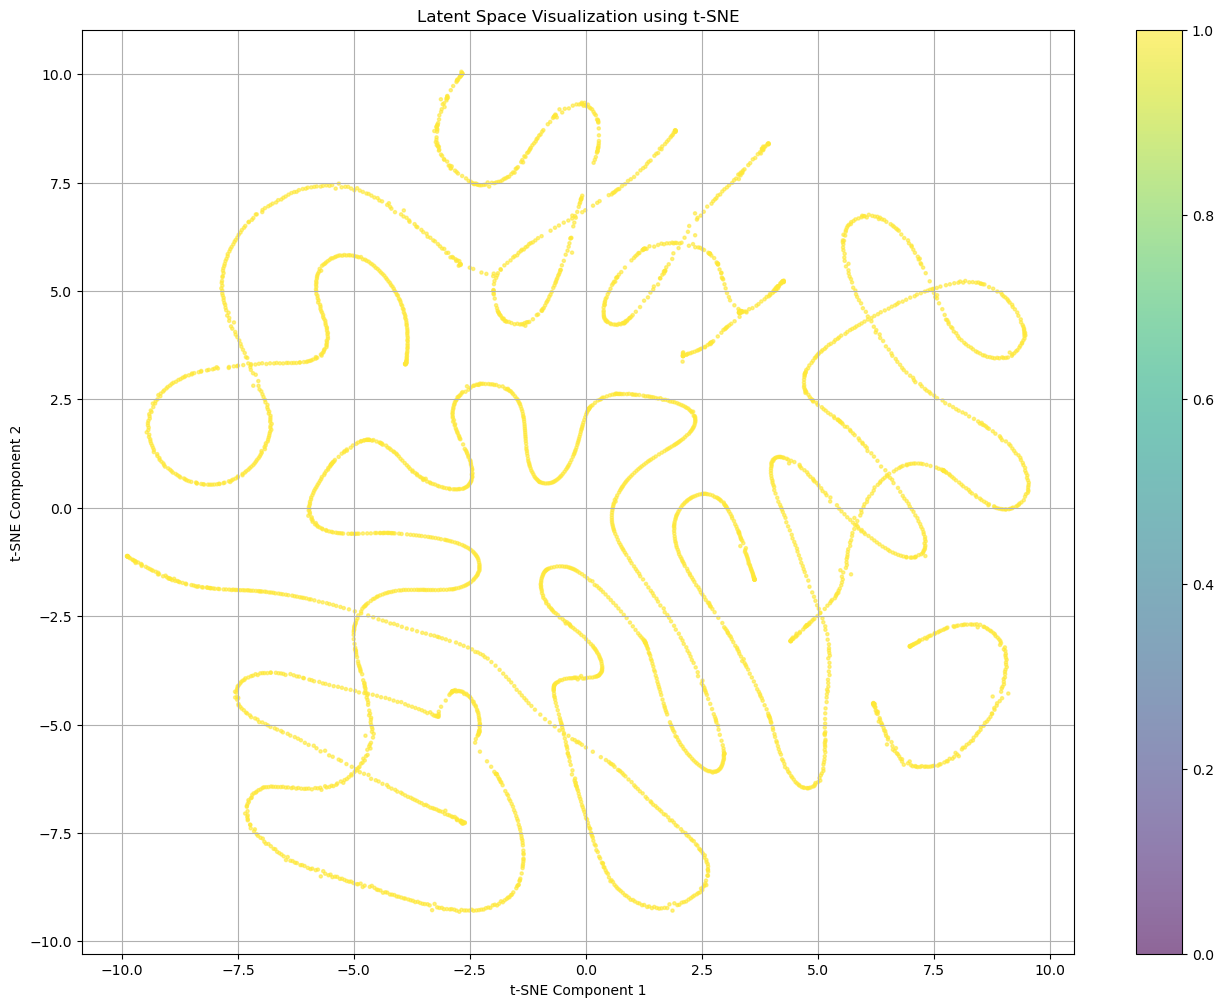

In [109]:
#Cell 13 Function to visualize the latent space with a color gradient
from sklearn.manifold import TSNE

def visualize_latent_space(model, data, perplexity=5, learning_rate=200, n_iter=250):
    # Encode data into the latent space
    latent_means, _ = model.encode(tf.convert_to_tensor(data, dtype=tf.float32))
    latent_means_np = latent_means.numpy()
    
    # Use t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=n_iter)
    latent_2d = tsne.fit_transform(latent_means_np)
    
    # Create a color map for the latent points
    norm = plt.Normalize(vmin=np.min(latent_means_np), vmax=np.max(latent_means_np))
    cmap = plt.cm.cividis  # You can change the colormap to 'plasma', 'inferno', etc.
    colors = cmap(norm(latent_means_np).sum(axis=1))  # Coloring based on the sum of latent variables
    
    # Plot the 2D t-SNE result with the color map
    plt.figure(figsize=(16, 12))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=colors, s=5, alpha=0.6)
    plt.colorbar(scatter)  # Add a color bar for the gradient
    plt.title('Latent Space Visualization using t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.show()

# Visualize latent space for one of the processed datasets
visualize_latent_space(vae, processed_data[0])

In [ ]:
# Cell 9 (modified to retain augmented data length)
def download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, original_filenames, directory='augmented_data'):
    if not os.path.exists(directory):
        os.makedirs(directory)

    for i, (augmented_data, scaler, original_df, original_filename) in enumerate(zip(augmented_datasets, scalers, original_data_frames, original_filenames)):
        # Inverse transform the augmented data
        augmented_xyz = scaler.inverse_transform(augmented_data[:, :3])
        
        # Round to integers
        augmented_xyz_int = np.rint(augmented_xyz).astype(int)
        
        # Get pen status from augmented data
        pen_status = augmented_data[:, 3].astype(int)
        
        # Prepare pressure, azimuth, altitude data
        original_paa = original_df[['pressure', 'azimuth', 'altitude']].values
        
        if len(augmented_data) > len(original_paa):
            original_paa = repeat_backwards(original_paa, len(augmented_data))
        
        # Round pressure, azimuth, altitude to integers
        original_paa_int = np.rint(original_paa).astype(int)
        
        # Generate new timestamps: start at 0, alternately incrementing by 7 and 8
        new_timestamps = np.zeros(len(augmented_data), dtype=int)
        increment_sequence = [7, 8]
        current_time = 0
        for idx in range(len(augmented_data)):
            new_timestamps[idx] = current_time
            current_time += increment_sequence[idx % 2]  # Alternate between 7 and 8

        # Replace the timestamp in the 3rd column of augmented_xyz_int
        augmented_xyz_int[:, 2] = new_timestamps

        # Combine all data: XYZ, pen status, pressure, azimuth, altitude
        augmented_data_original_scale = np.column_stack((
            augmented_xyz_int,
            pen_status,
            original_paa_int[:len(augmented_data)]
        ))

        # Construct the new file name to match the original file name
        augmented_filename = f"augmented_{original_filename}"
        augmented_file_path = os.path.join(directory, augmented_filename)

        # Save the augmented data to a file
        np.savetxt(augmented_file_path, augmented_data_original_scale, fmt='%d', delimiter=' ')

        print(f"Augmented data saved to {augmented_file_path}")
        print(f"Shape of augmented data for {original_filename}: {augmented_data_original_scale.shape}")

# Example call to the function
download_augmented_data_with_modified_timestamp(augmented_datasets, scalers, original_data_frames, input_filenames)

# Add this diagnostic print statement after generating augmented_datasets
print("Shapes of augmented datasets:")
for i, aug_data in enumerate(augmented_datasets):
    print(f"Shape of augmented dataset {i+1}: {aug_data.shape}")
